# Восстановитель НП

## Код

In [103]:
import geopandas as gpd

TOLERANCE_KM = 35

def remove_duplicates(
    gdf: gpd.GeoDataFrame,
    name_column: str,
    geometry_column: str,
    population_column: str
) -> gpd.GeoDataFrame:
    
    # Создание пространственного индекса
    gdf = gdf.reset_index(drop=True)
    gdf['duplicate'] = False
    
    spatial_index = gdf.sindex
    
    for idx, row in gdf.iterrows():
        if gdf.at[idx, 'duplicate']:
            continue
        
        # Поиск ближайших точек в пределах допустимого расстояния
        possible_matches_index = list(spatial_index.intersection(row[geometry_column].buffer(TOLERANCE_KM).bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        exact_matches = possible_matches[possible_matches[name_column] == row[name_column]]
        exact_matches = exact_matches[exact_matches[geometry_column].distance(row[geometry_column]) < TOLERANCE_KM]
        
        # Проверка разницы в населении
        exact_matches = exact_matches[exact_matches[population_column].apply(lambda x: x <= row[population_column] * 10 and x >= row[population_column] / 10)]

        if len(exact_matches) > 1:
            # Найти индекс строки с наибольшим населением
            max_population_index = exact_matches[population_column].idxmax()

            # Отметить все остальные строки как дубликаты, кроме той, у которой наибольшее население
            duplicate_indices = exact_matches.index.difference([max_population_index])
            
            # Помечаем все, кроме одной (с наибольшим населением), как дубликаты
            gdf.loc[duplicate_indices, 'duplicate'] = True

    return gdf

In [3]:
import osmnx as ox
from shapely import Polygon, MultiPolygon

OSM_TAGS = {
  'place': [
    'city',
    'town',
    'village',
    'hamlet',
    'isolated_dwelling'
  ]
}

def fetch_towns(polygon : Polygon | MultiPolygon):
  gdf = ox.features_from_polygon(polygon, tags = OSM_TAGS)
  gdf.geometry = gdf.representative_point()
  gdf['population'] = gdf['population'].fillna(0)
  gdf["population"] = gdf["population"].apply(lambda s: str(s).split(" ", maxsplit=1)[0]).apply(int)
  gdf = gdf[gdf["population"] > 0].reset_index()
  return gdf[["geometry", "name", "population"]]

## Применение

In [8]:
import requests
import pandas as pd

CRS = 4326
URL = 'http://10.32.1.107:5300/'

def get_country_regions(country_id : int) -> pd.DataFrame:
    res = requests.get(URL + 'api/v1/all_territories', {
        'parent_id':country_id
    })
    return gpd.GeoDataFrame.from_features(res.json()['features'], crs=CRS).set_index('territory_id', drop=True)

def get_countries_without_geometry() -> pd.DataFrame:
    res = requests.get(URL + 'api/v1/all_territories_without_geometry')
    return pd.DataFrame(res.json()).set_index('territory_id', drop=True)

def get_regions():
    countries = get_countries_without_geometry()
    countries_ids = countries.index
    countries_regions = [get_country_regions(country_id) for country_id in countries_ids]
    return pd.concat(countries_regions)

In [10]:
regions = get_regions()

In [11]:
REGIONS_DICT = {
  1: 'Ленинградская область',
  3138: 'Санкт-Петербург',
  3268: 'Москва',
  3427: 'Волгоградская область',
  3902: 'Тульская область',
  4013: 'Омская область',
  4437: 'Краснодарский край',
  4882: 'Тюменская область',
  5188: 'Московская область',
}

regions = regions[~regions.index.isin(REGIONS_DICT.keys())]

Качаем города с ОСМ

In [15]:
from tqdm import tqdm

for region_id in tqdm(regions.index):
  region_polygon = regions.loc[region_id].geometry
  towns = fetch_towns(region_polygon)
  towns.to_parquet(f'./data/towns/{region_id}_osm.parquet')

/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
 97%|█████████▋| 35/36 [48:04<01:59, 119.66s/it]/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/osmnx/_overpass.py:254: UserWarning: This area is 17 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
100%|██████████| 36/36 [48:33<00:00, 80.94s/it] 


Убираем дубликаты

In [104]:
from tqdm import tqdm

for region_id in tqdm(regions.index):
  towns = gpd.read_parquet(f'./data/towns/{region_id}_osm.parquet')
  crs = towns.estimate_utm_crs()
  towns = towns.to_crs(crs)
  towns = remove_duplicates(towns, 'name', 'geometry', 'population')
  towns = towns[~towns['duplicate']]
  towns.to_crs(4326).to_parquet(f'./data/towns/{region_id}.parquet')

  0%|          | 0/36 [00:00<?, ?it/s]/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
  3%|▎         | 1/36 [00:00<00:33,  1.05it/s]/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future versio

Качаем территории и по ним обрезаем

In [105]:
def get_region_territories(region_id : int) -> dict[int, gpd.GeoDataFrame]:
    res = requests.get(URL + 'api/v1/all_territories', {
        'parent_id': region_id,
        'get_all_levels': True
    })
    gdf = gpd.GeoDataFrame.from_features(res.json()['features'], crs=4326)
    df = pd.json_normalize(gdf['territory_type']).rename(columns={
        'name':'territory_type_name'
    })
    gdf = pd.DataFrame.join(gdf, df).set_index('territory_id', drop=True)
    return {level:gdf[gdf['level'] == level] for level in set(gdf.level)}

def get_region_adm_units(region_id : int):
    gdfs = get_region_territories(region_id)
    gdfs = list(gdfs.values())
    if len(gdfs) == 1:
        return gdfs[0]
    big_gdf = gdfs[0]
    small_gdf = gdfs[-1]
    big_gdf = big_gdf.overlay(small_gdf, how='difference').explode()[['geometry']]
    small_gdf = small_gdf.explode()[['geometry']]
    return pd.concat([big_gdf, small_gdf]).reset_index()

In [108]:
towns.explore()

In [106]:
from tqdm import tqdm
from townsnet.voronizer import Voronizer

for region_id in tqdm(regions.index):
  units = get_region_adm_units(region_id)
  units = units.reset_index()
  towns = gpd.read_parquet(f'./data/towns/{region_id}.parquet')
  towns = towns.clip(units)
  voronizer = Voronizer(towns, units)
  voronoi_towns = voronizer.run()
  # towns = towns.sort_index()
  # voronoi_towns = voronoi_towns.sort_index()
  # towns['geometry'] = voronoi_towns['geometry']
  towns.to_file(f'./data/towns/{region_id}.geojson')

  0%|          | 0/36 [00:00<?, ?it/s]/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
  3%|▎         | 1/36 [00:02<01:19,  2.26s/it]/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instea

KeyboardInterrupt: 

In [ ]:
gpd.read_parquet(f'./data/towns/{12640}_osm.parquet')

/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


,geometry,name,population
0,POINT (40.27974 44.21016),Усть-Сахрай,304
1,POINT (40.28793 44.13815),Новопрохладное,170
2,POINT (40.31353 44.35057),Севастопольская,644
3,POINT (40.41116 44.35196),Новосвободная,623
4,POINT (40.31074 44.29257),Победа,145
...,...,...,...
406,POINT (38.94977 44.98727),Яблоновский,32039
407,POINT (38.93156 45.01893),Новая Адыгея,2209
408,POINT (38.95508 45.03108),Перекатный,237
409,POINT (38.94956 45.06163),Краснодар,948827


In [ ]:
towns = remove_duplicates(gpd.read_parquet(f'./data/towns/{12640}_osm.parquet').to_crs(3857), 'name', 'geometry', 'population')

/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [ ]:
towns['duplicate'].any()

True

In [ ]:
voronoi_towns

,geometry
0,"POLYGON ((294808.611 7159637.812, 294909.542 7..."
1,"POLYGON ((288173.64 7158103.134, 288168.964 71..."
2,"POLYGON ((283052.017 7167485.939, 283113.254 7..."
3,"POLYGON ((609233.643 6794782.232, 609190.369 6..."
4,"POLYGON ((588406.902 6782129.953, 588377.869 6..."
...,...
685,"POLYGON ((338441.907 6786913.528, 334851.716 6..."
686,"POLYGON ((336763.781 6789536.126, 328386.136 6..."
687,"POLYGON ((339488.006 6781902.781, 336963.027 6..."
688,"POLYGON ((329704.443 6788171.98, 329568.434 67..."


/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/geopandas/plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


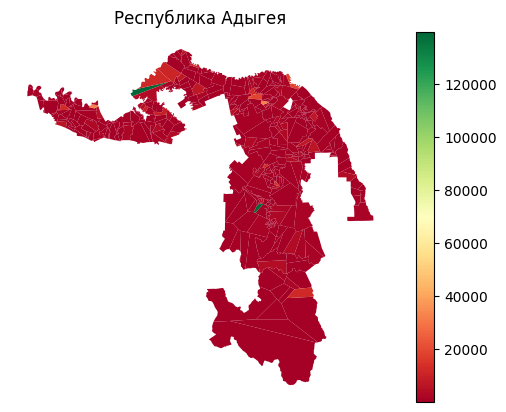

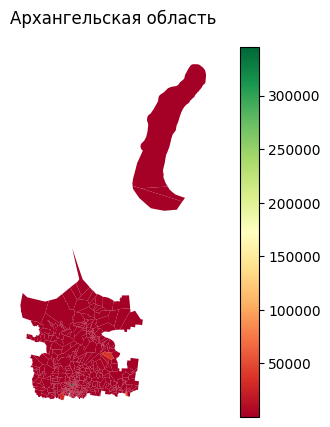

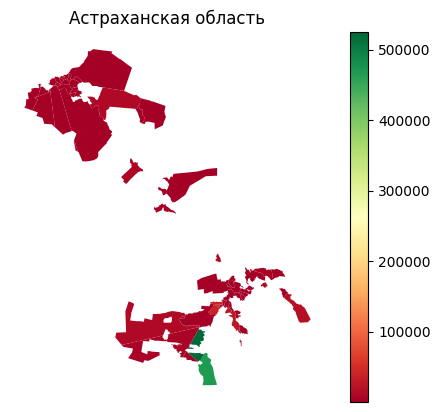

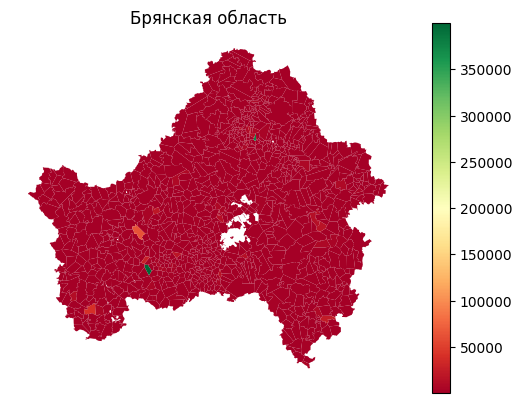

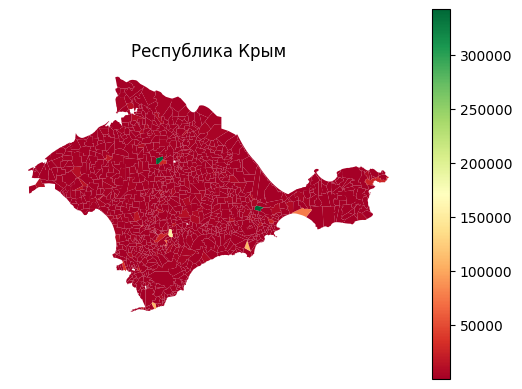

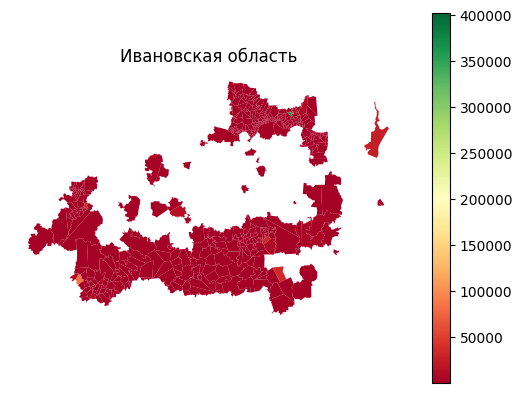

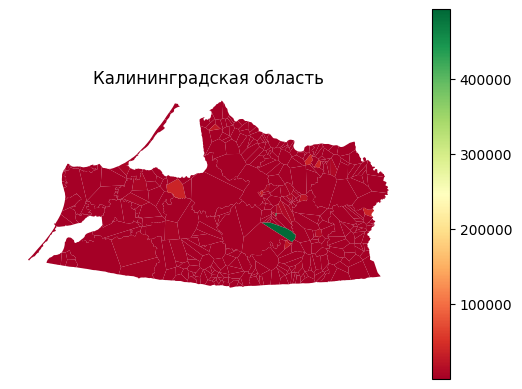

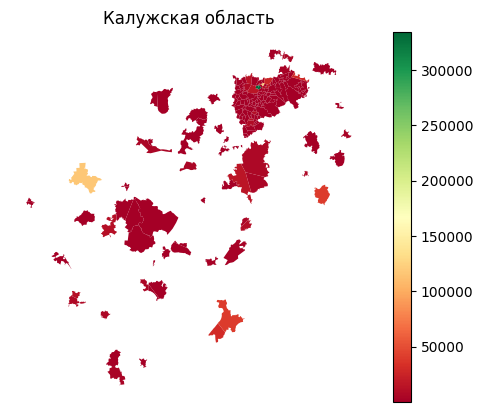

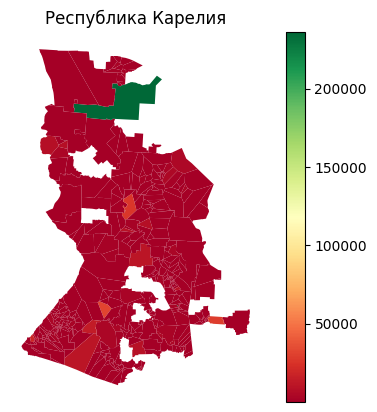

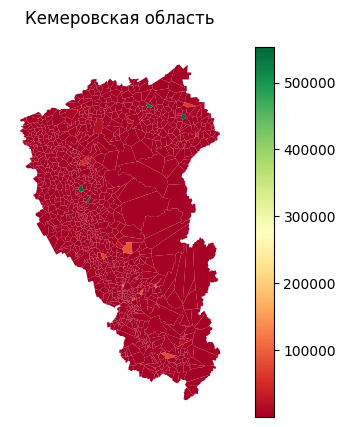

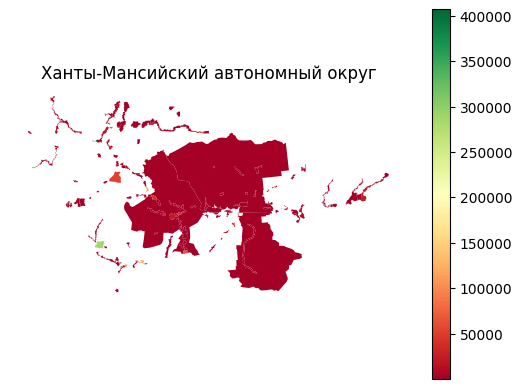

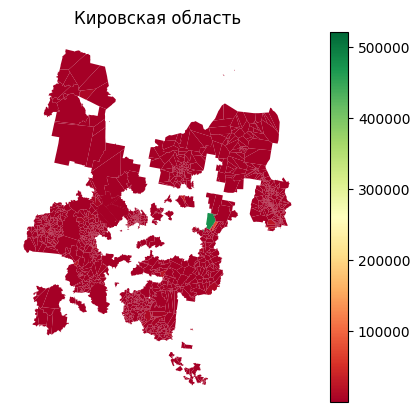

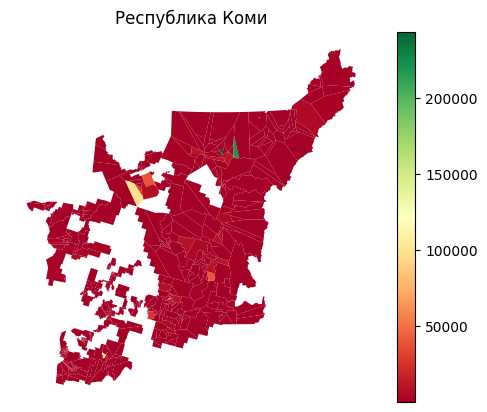

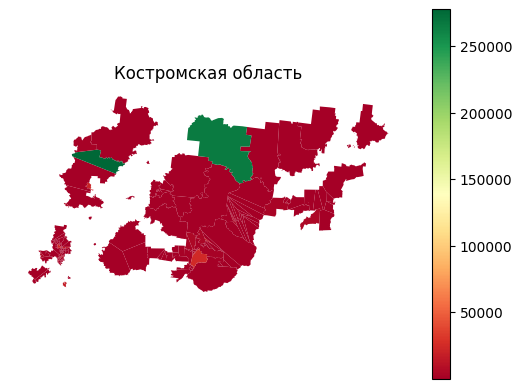

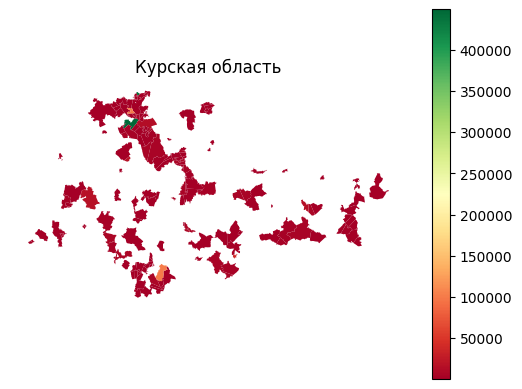

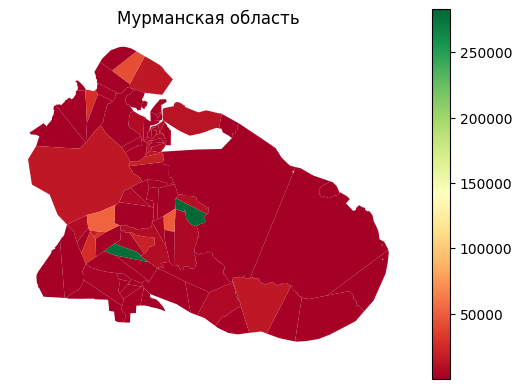

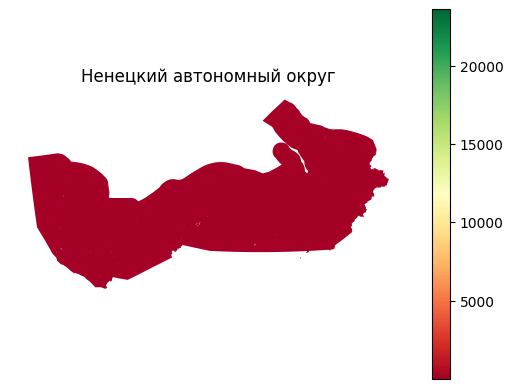

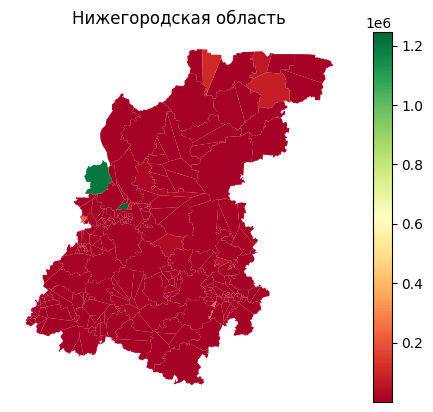

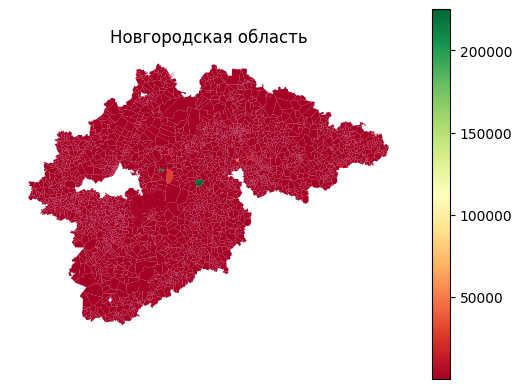

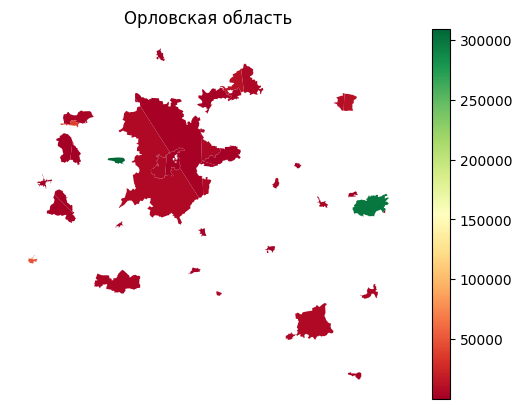

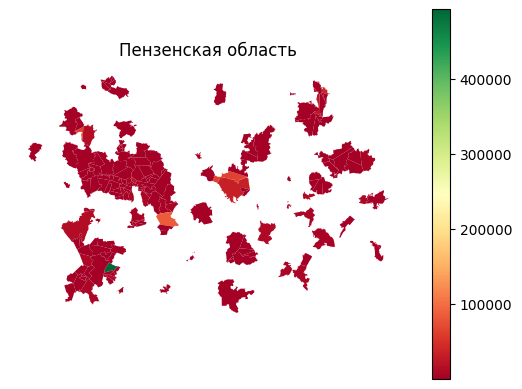

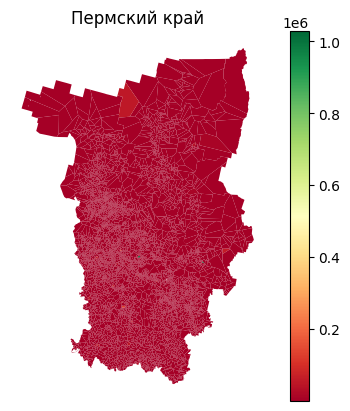

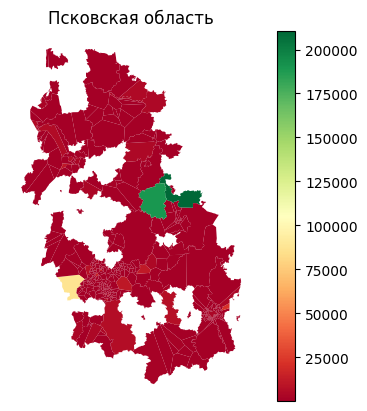

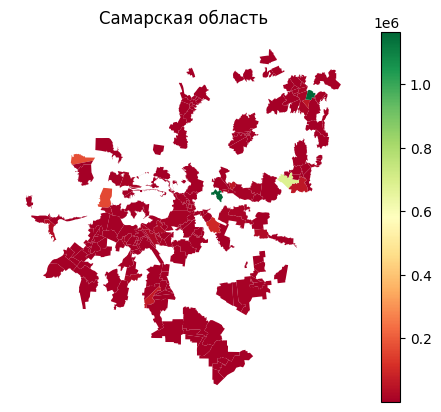

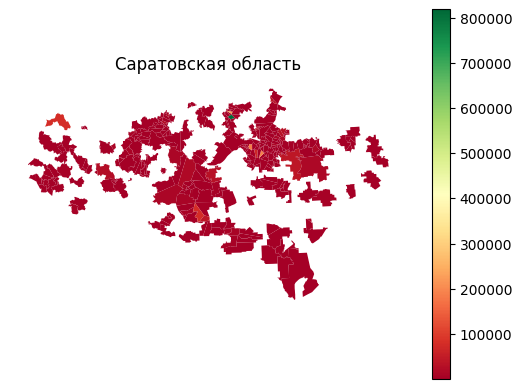

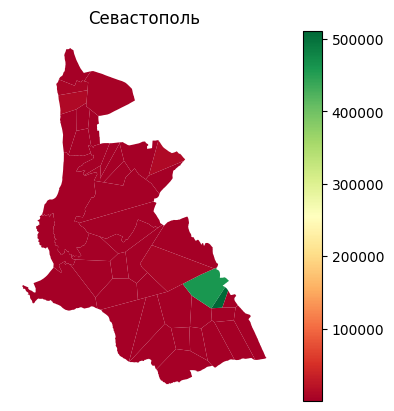

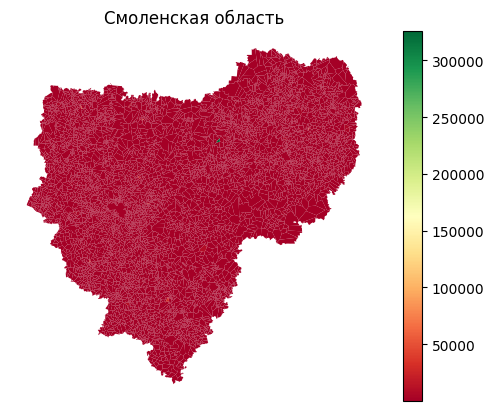

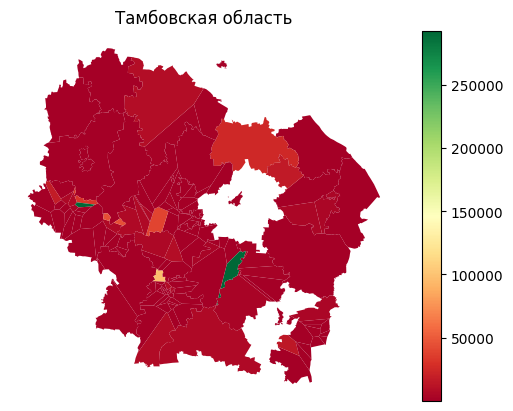

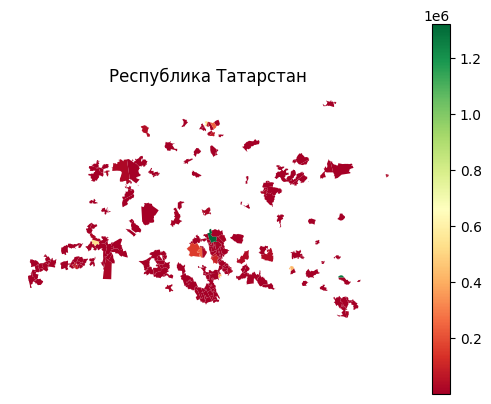

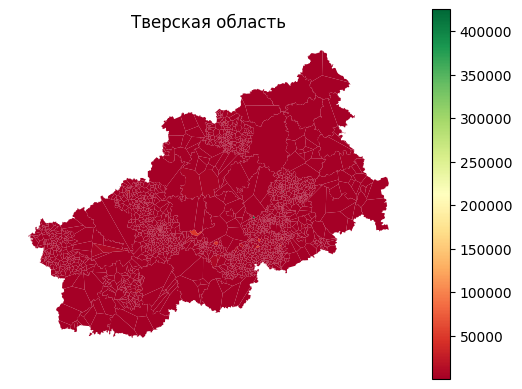

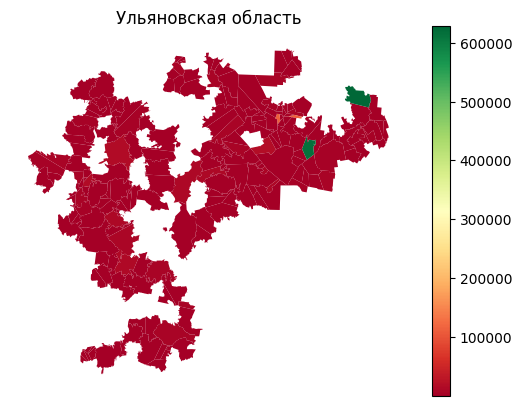

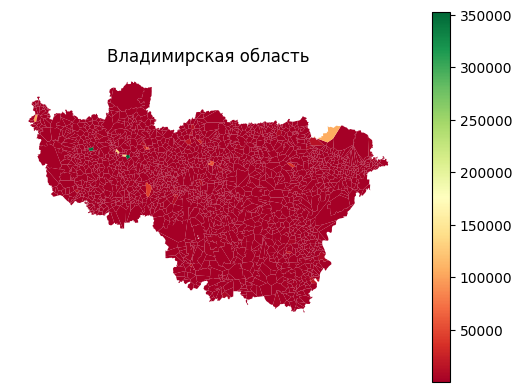

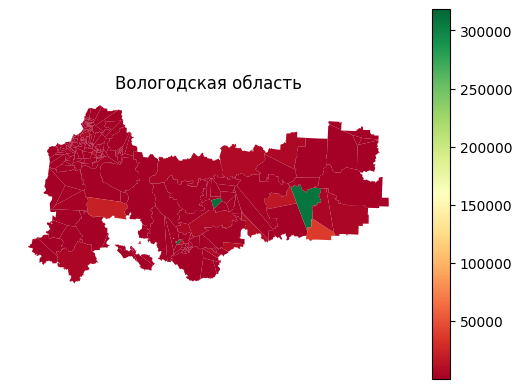

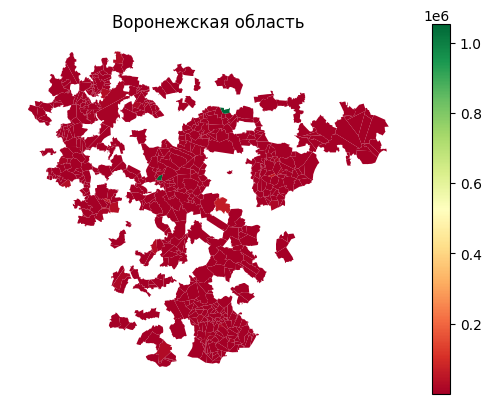

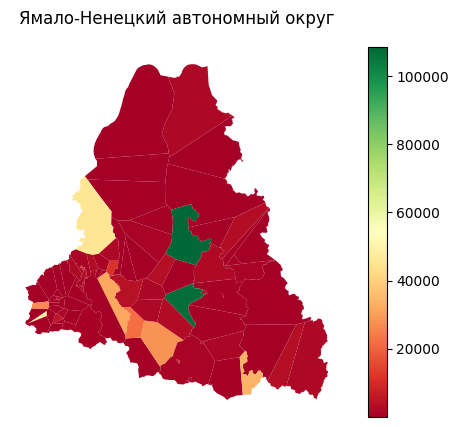

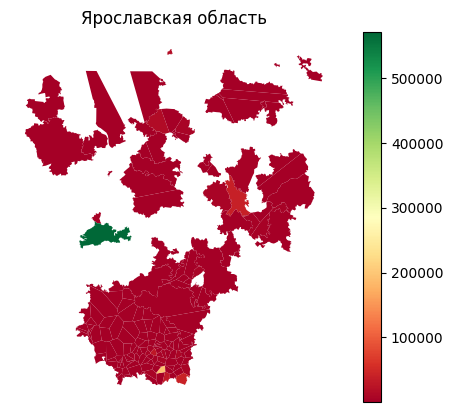

In [ ]:
for region_id in regions.index:
  towns = gpd.read_file(f'./data/towns/{region_id}.geojson')
  ax = towns.plot(column='population', cmap='RdYlGn', legend=True)
  ax.set_axis_off()
  ax.set_title(regions.loc[region_id, 'name'])